In [1]:
from google.colab import drive
drive.mount ("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd/content/drive/My Drive

/content/drive/My Drive


In [3]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import GaussianNoise
import matplotlib.pyplot as plt

import os.path
from pathlib import Path
import numpy as np
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers import Dense
from numpy import load

Using TensorFlow backend.


DISCRIMANTOR

In [0]:
def discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  in_src = Input(shape=image_shape)
  in_tar = Input(shape=image_shape)
  merged = Concatenate()([in_src, in_tar])
  #c64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  #128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  #c256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  #c512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  #c512
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  #c1
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  model = Model([in_src, in_tar], patch_out)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  model.summary()
  return model

GENERATOR

In [0]:
# define an encoder block
def encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

def generator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  e1 = encoder_block(in_image, 64, batchnorm=False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  model = Model(in_image, out_image)
  model.summary()
  return model

GAN

In [0]:
def gan(g_model, d_model, image_shape):
  d_model.trainable = False
  in_src_img = Input(shape=image_shape)
  gen_out = g_model(in_src_img)
  dis_out = d_model([in_src_img, gen_out])
  model = Model(in_src_img, [dis_out, gen_out])
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  model.summary()
  return model

LOADING **REAL** **SAMPLES**

In [0]:
def load_real_samples(filename):
	
	data = load(filename)
	
	X1, X2 = data['arr_0'], data['arr_1']

	return [X1, X2]

GENERATING REAL SAMPLES

In [0]:
def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

GENERATING FAKE SAMPLES

In [0]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

SAVING SUBPLOTS AND MODELS

In [0]:
def summarize_performance(j, g_model, dataset, n_samples=3):
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  fig=plt.figure()
  for p in range(n_samples):
    plt.subplot(3, n_samples, 1 + p)
    plt.axis('off')
    plt.imshow(X_realA[p])
  for p in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + p)
    plt.axis('off')
    plt.imshow(X_fakeB[p])
  for p in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + p)
    plt.axis('off')
    plt.imshow(X_realB[p])
  filename1 = f'/content/drive/My Drive/pix2pix/subplots/plot_{j}.png'
  fig.savefig(filename1)
  filename2 = f'/content/drive/My Drive/pix2pix/g_model/plot_{j}.h5'
  g_model.save(filename2)
  print('saved')
  
  
	
	
	
	
	



In [0]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  for j in range(n_epochs):
    for i in range(len(trainA)):
      [X_realA, X_realB], y_real = [trainA[[i]],trainB[[i]]], ones((n_batch, n_patch, n_patch, 1))
      X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
      real_loss = d_model.train_on_batch([X_realA, X_realB], y_real)
      fake_loss = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
      gan_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
      

      if i==range(len(trainA))[-1] and j%10==0:
        print(f"epoch={j}, sample_no={i} , real_loss={real_loss} , fake_loss={fake_loss} , gan_loss={gan_loss}")
        summarize_performance(j, g_model, dataset, n_samples=3)

        

In [0]:
dataset= load_real_samples('maps_256.npz')

In [0]:
image_shape = dataset[0].shape[1:]

In [14]:
g_model= generator(image_shape=(256,256,3))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [15]:
d_model= discriminator(image_shape)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_8[0][0]        

In [16]:
gan_model= gan(g_model, d_model, image_shape)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_1[1][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch=0, sample_no=1095 , real_loss=0.010055091232061386 , fake_loss=0.04152769222855568 , gan_loss=12.31715202331543
saved
epoch=10, sample_no=1095 , real_loss=0.0013479108456522226 , fake_loss=0.02842717058956623 , gan_loss=12.757484436035156
saved
epoch=20, sample_no=1095 , real_loss=0.001968787983059883 , fake_loss=0.0007567684515379369 , gan_loss=16.280912399291992
saved
epoch=30, sample_no=1095 , real_loss=0.0027284715324640274 , fake_loss=0.0677838921546936 , gan_loss=12.967903137207031
saved
epoch=40, sample_no=1095 , real_loss=0.0005776750040240586 , fake_loss=0.21694353222846985 , gan_loss=15.867048263549805
saved
epoch=50, sample_no=1095 , real_loss=0.020444003865122795 , fake_loss=0.004424300976097584 , gan_loss=12.864553451538086
saved
epoch=60, sample_no=1095 , real_loss=0.004592962097376585 , fake_loss=0.009976205416023731 , gan_loss=13.079670906066895
saved
epoch=70, sample_no=1095 , real_loss=0.010721239261329174 , fake_loss=0.0014849401777610183 , gan_loss=14.37939548

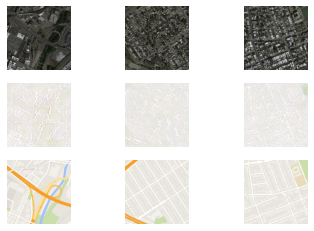

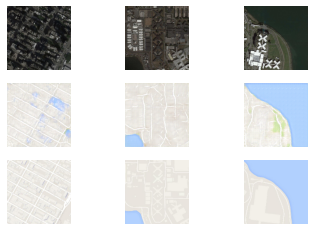

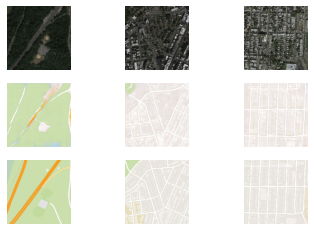

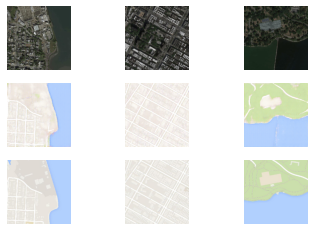

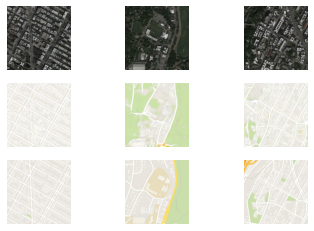

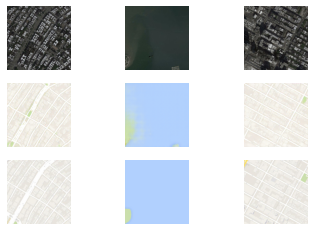

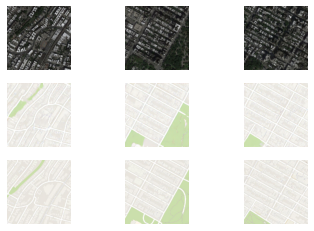

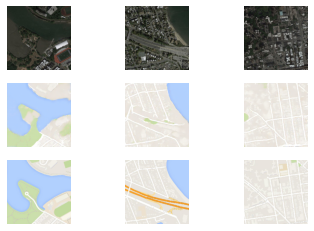

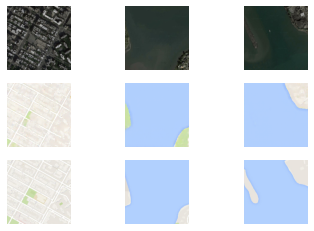

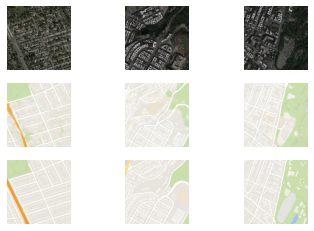

In [17]:
train(d_model, g_model, gan_model, dataset)